In [ ]:
# Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

In [ ]:
# 1. Data Download and Initial Visualization
data = pd.DataFrame(yf.download("ARTO.JK", start="2020-08-01", end="2024-08-01"))

[*********************100%***********************]  1 of 1 completed


In [ ]:
import yfinance as yf

In [ ]:
import pandas as pd
stock_data = {"Price" : [100, 110, 120],
              "Tanggal" : ["1 Agustus", "2 Agustus", "3 Agustus"],
              "Volume" : [1, 2, 3]}
data = pd.DataFrame(stock_data)

In [ ]:
data

,Price,Tanggal,Volume
0,100,1 Agustus,1
1,110,2 Agustus,2
2,120,3 Agustus,3


In [ ]:
#Feature Selection
selected_feature = 'Close'
data = data[[selected_feature]]

In [ ]:
data.head(5)

Price,Close
Ticker,ARTO.JK
Date,
2020-08-03,2272.359619
2020-08-04,2280.653076
2020-08-05,2280.653076
2020-08-06,2280.653076
2020-08-07,2272.359619


In [ ]:
data.tail(5)

Price,Close
Ticker,ARTO.JK
Date,
2024-07-25,2430.0
2024-07-26,2570.0
2024-07-29,2490.0
2024-07-30,2670.0
2024-07-31,2700.0



Visualizing Closing Prices...


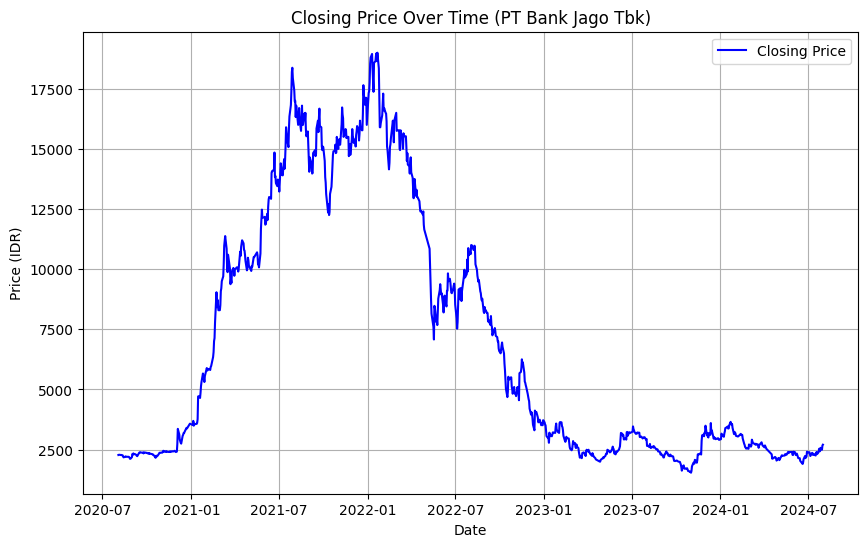

In [ ]:
# Plot the closing price over time
print("\nVisualizing Closing Prices...")
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Closing Price', color='blue')
plt.title('Closing Price Over Time (PT Bank Jago Tbk)')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
data.isnull().sum()

,,0
Price,Ticker,
Close,ARTO.JK,0


In [ ]:
# 2. Outlier Detection and Handling

# Detect Outliers using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
data['Outlier_ISO'] = iso_forest.fit_predict(data['Close'].values.reshape(-1, 1))
print("Isolation Forest Outliers Detected!")

data['Outlier_ISO'].value_counts()

Isolation Forest Outliers Detected!


,count
Outlier_ISO,
1,819
-1,145


In [ ]:
# Detect Outliers using Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.15)
data['Outlier_LOF'] = lof.fit_predict(data['Close'].values.reshape(-1, 1))
print("Local Outlier Factor (LOF) Outliers Detected!")

data['Outlier_LOF'].value_counts()

Local Outlier Factor (LOF) Outliers Detected!


,count
Outlier_LOF,
1,820
-1,144


In [ ]:
# Combine outliers into a single column
data['Outlier'] = np.where((data['Outlier_ISO'] == -1) | (data['Outlier_LOF'] == -1), -1, 1)
print(f"Total Outliers Detected: {len(data[data['Outlier'] == -1])}")

Total Outliers Detected: 225


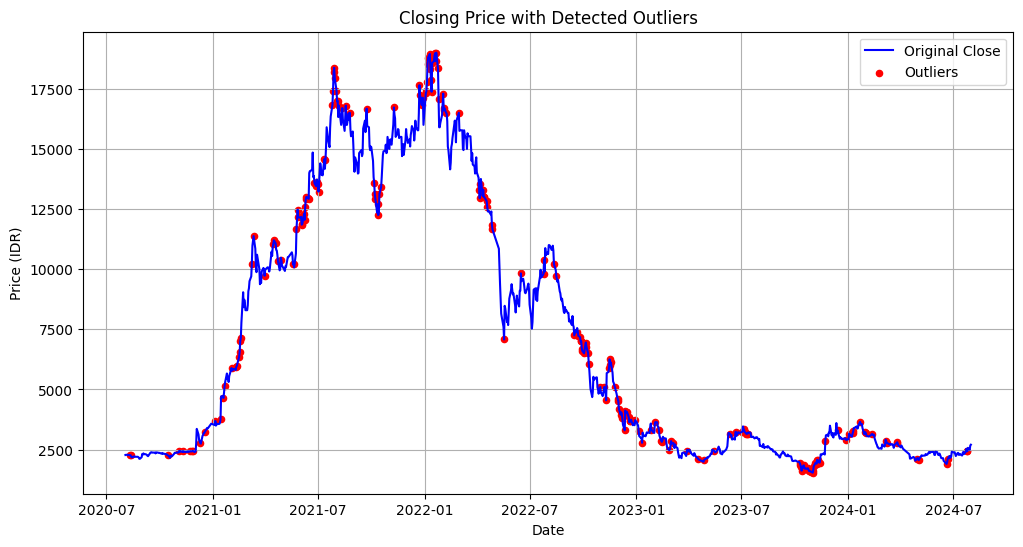

In [ ]:
# Plot closing prices with outliers
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Original Close', color='blue')
plt.scatter(data.index[data['Outlier'] == -1],
            data['Close'][data['Outlier'] == -1],
            color='red', label='Outliers', s=20)
plt.title('Closing Price with Detected Outliers')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Handle Outliers by replacing them with the rolling mean
data['Cleaned_Close'] = data['Close'].where(data['Outlier'] == 1, data['Close'].rolling(5, min_periods=1).mean())
replaced_with_rolling_mean = data[data['Outlier'] == -1][['Close', 'Cleaned_Close']].head()
print(replaced_with_rolling_mean)

Price             Close Cleaned_Close
Ticker          ARTO.JK              
Date                                 
2020-08-11  2255.773193   2272.359717
2020-08-12  2255.773193   2267.383740
2020-10-15  2264.066406   2293.922266
2020-11-04  2446.518799   2385.148438
2020-11-10  2429.932129   2421.638867


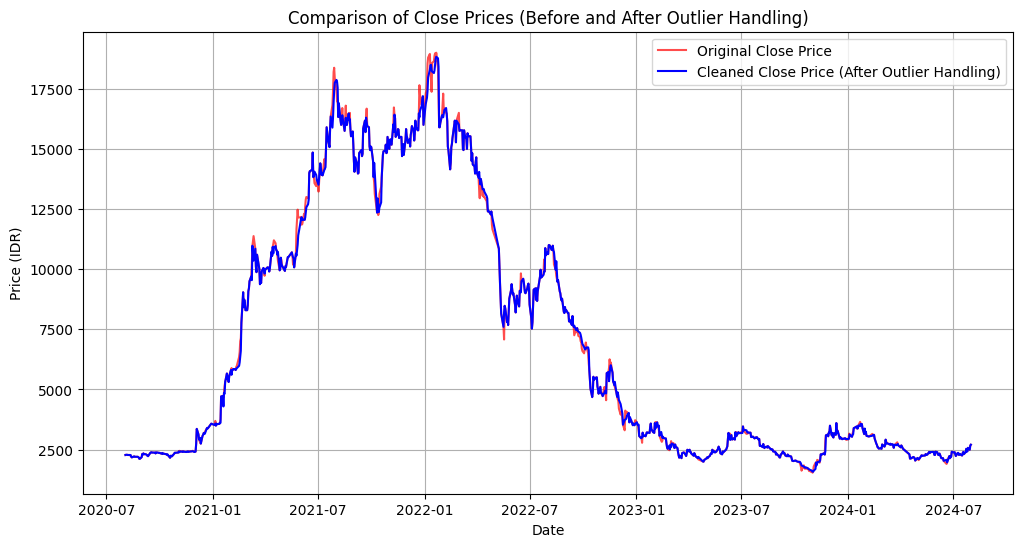

In [ ]:
# Plot closing prices before and after outlier handling
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'],
         label='Original Close Price',
         color='red', alpha=0.7)
plt.plot(data.index, data['Cleaned_Close'],
         label='Cleaned Close Price (After Outlier Handling)',
         color='blue')
plt.title('Comparison of Close Prices (Before and After Outlier Handling)')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 3. Feature Scaling and Splitting

# Normalize the cleaned closing prices for inputs and outputs using Min-Max Scaling
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_input.fit_transform(data['Cleaned_Close'].values.reshape(-1, 1))


In [ ]:
data['Scaled_Close'] = scaled_data
print("\nData After Min-Max Scaling (First 5 Rows):")
print(data[['Close', 'Scaled_Close']].head())


Data After Min-Max Scaling (First 5 Rows):
Price             Close Scaled_Close
Ticker          ARTO.JK             
Date                                
2020-08-03  2272.359619     0.040248
2020-08-04  2280.653076     0.040729
2020-08-05  2280.653076     0.040729
2020-08-06  2280.653076     0.040729
2020-08-07  2272.359619     0.040248


In [ ]:
# Get descriptive statistics for both Cleaned_Close and Scaled_Close
print("\nDescriptive Statistics for Cleaned_Close and Scaled_Close:")
print(data[['Cleaned_Close', 'Scaled_Close']].describe())


Descriptive Statistics for Cleaned_Close and Scaled_Close:
Price  Cleaned_Close Scaled_Close
Ticker                           
count     964.000000   964.000000
mean     6974.510425     0.312805
std      5266.347052     0.305260
min      1578.000000     0.000000
25%      2421.229150     0.048877
50%      3603.789185     0.117423
75%     10850.000000     0.537445
max     18830.000000     1.000000


In [ ]:
# Split the data into training, testing, and validation set (70% train, 15% test, 15% validation)
# Define proportions
train_size = int(len(scaled_data) * 0.7)  # 70% training
val_size = int(len(scaled_data) * 0.15)   # 15% validation

# Split the data
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

print(f"Training Data Size: {len(train_data)}, Testing Data Size: {len(test_data)}, Validation Data Size: {len(val_data)}")

Training Data Size: 674, Testing Data Size: 146, Validation Data Size: 144


In [ ]:
# Prepare outputs
train_output = scaled_data[:train_size]
val_output = scaled_data[train_size:train_size + val_size]
test_output = scaled_data[train_size + val_size:]

In [ ]:
# Function to prepare sequences
def prepare_data(data, output, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(output[i + n_steps, 0])
    return np.array(X), np.array(y)

# Sequence length
n_steps = 60
X_train, y_train = prepare_data(train_data, train_output, n_steps)
X_val, y_val = prepare_data(val_data, val_output, n_steps)
X_test, y_test = prepare_data(test_data, test_output, n_steps)

# Reshape for GRU
X_train = X_train.reshape((X_train.shape[0], n_steps, 1))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1))

In [ ]:
# 4. GRU Model Construction and Training

# Function to build the GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(units=64, return_sequences=True),
        Dropout(0.3),
        GRU(units=32),
        Dense(units=1, use_bias = True)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [ ]:
# Build and compile the GRU model
gru_model = build_gru_model((n_steps, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,993 (378.88 KB)

 Trainable params: 96,993 (378.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# Train the model
history = gru_model.fit(
    X_train, y_train,
    epochs=200, batch_size=32,
    validation_data=(X_val, y_val),
    verbose=2, callbacks= [early_stopping]
)

Epoch 1/200
20/20 - 19s - 962ms/step - loss: 0.0794 - val_loss: 0.0040
Epoch 2/200
20/20 - 4s - 190ms/step - loss: 0.0087 - val_loss: 1.6426e-04
Epoch 3/200
20/20 - 3s - 144ms/step - loss: 0.0039 - val_loss: 4.4939e-04
Epoch 4/200
20/20 - 7s - 327ms/step - loss: 0.0033 - val_loss: 1.6799e-04
Epoch 5/200
20/20 - 4s - 183ms/step - loss: 0.0028 - val_loss: 1.4269e-04
Epoch 6/200
20/20 - 3s - 143ms/step - loss: 0.0028 - val_loss: 1.5860e-04
Epoch 7/200
20/20 - 6s - 295ms/step - loss: 0.0029 - val_loss: 1.4720e-04
Epoch 8/200
20/20 - 4s - 217ms/step - loss: 0.0025 - val_loss: 1.3779e-04
Epoch 9/200
20/20 - 5s - 252ms/step - loss: 0.0026 - val_loss: 1.8103e-04
Epoch 10/200
20/20 - 4s - 188ms/step - loss: 0.0025 - val_loss: 1.6924e-04
Epoch 11/200
20/20 - 3s - 171ms/step - loss: 0.0024 - val_loss: 1.3100e-04
Epoch 12/200
20/20 - 3s - 144ms/step - loss: 0.0021 - val_loss: 1.3986e-04
Epoch 13/200
20/20 - 5s - 257ms/step - loss: 0.0023 - val_loss: 2.0853e-04
Epoch 14/200
20/20 - 5s - 251ms/step 

In [ ]:
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 290,981 (1.11 MB)

 Trainable params: 96,993 (378.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 193,988 (757.77 KB)

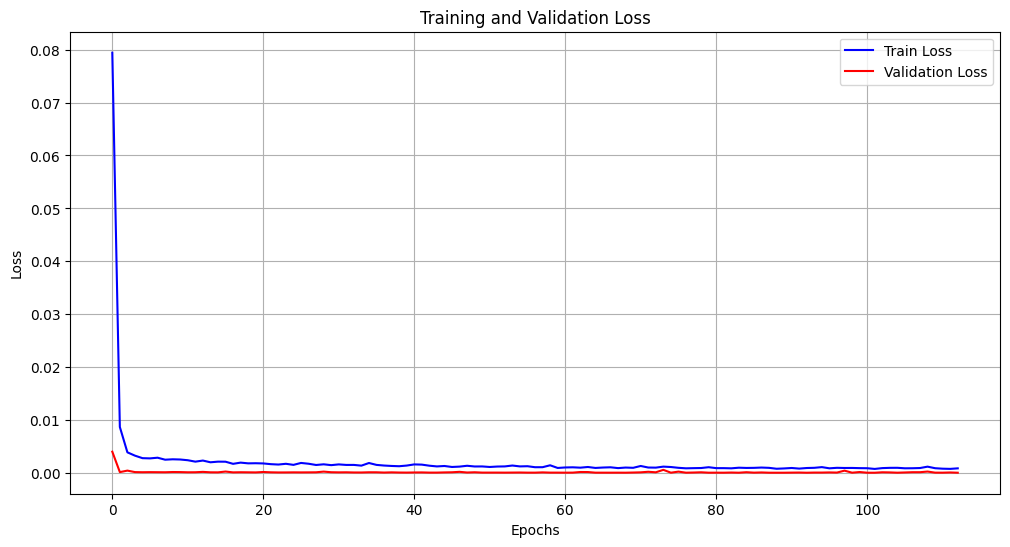

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 5. Model Evaluation and Visualization

# Evaluate Training Performance
train_pred = gru_model.predict(X_train)
train_pred_inv = scaler_input.inverse_transform(train_pred)
y_train_inv = scaler_input.inverse_transform(y_train.reshape(-1, 1))

train_mse = mean_squared_error(y_train_inv, train_pred_inv)
train_rmse = math.sqrt(train_mse)
train_mape = np.mean(np.abs((y_train_inv - train_pred_inv) / y_train_inv)) * 100

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


In [ ]:
# Evaluate Validation Performance
val_pred = gru_model.predict(X_val)
val_pred_inv = scaler_input.inverse_transform(val_pred)
y_val_inv = scaler_input.inverse_transform(y_val.reshape(-1, 1))

val_mse = mean_squared_error(y_val_inv, val_pred_inv)
val_rmse = math.sqrt(val_mse)
val_mape = np.mean(np.abs((y_val_inv - val_pred_inv) / y_val_inv)) * 100

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [ ]:
# Evaluate Test Performance
y_test_inv = scaler_input.inverse_transform(y_test.reshape(-1, 1))  # Actual test values
y_pred_inv = scaler_input.inverse_transform(gru_model.predict(X_test))  # Predicted values

test_mse = mean_squared_error(y_test_inv, y_pred_inv)
test_rmse = math.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [ ]:
# Plot predictions vs actual prices
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data.index[train_size + val_size + n_steps:],
    y=y_test_inv.flatten(),
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=data.index[train_size + val_size + n_steps:],
    y=y_pred_inv.flatten(),
    mode='lines',
    name='Predicted Prices',
    line=dict(color='red')
))
fig.update_layout(
    title="Stock Price Prediction (GRU) After Outlier Handling",
    xaxis_title="Date", yaxis_title="Price (IDR)"
)
fig.show()

In [ ]:
# Display Results
print("\nPerformance Metrics:")
print(f"{'Dataset':<12} {'MSE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print(f"{'-'*40}")
print(f"{'Training':<12} {train_mse:<10.4f} {train_rmse:<10.4f} {train_mape:<10.2f}")
print(f"{'Validation':<12} {val_mse:<10.4f} {val_rmse:<10.4f} {val_mape:<10.2f}")
print(f"{'Test':<12} {test_mse:<10.4f} {test_rmse:<10.4f} {test_mape:<10.2f}")


Performance Metrics:
Dataset      MSE        RMSE       MAPE (%)  
----------------------------------------
Training     191017.6150 437.0556   3.50      
Validation   14843.6023 121.8343   2.76      
Test         7221.8704  84.9816    2.67      
